In [ ]:
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [ ]:
# Import the required libraries.

import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
# Applying seed constant for reproducibility

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

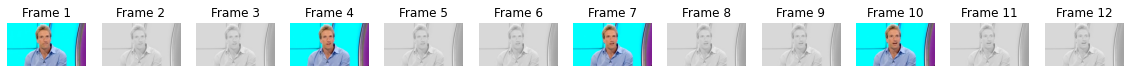

In [20]:
# Displaying frames from the dataset video samples

import matplotlib.pyplot as plt
import os
import random
import cv2

plt.figure(figsize=(20, 4))

# Path to the dataset folder
all_classes_names = os.listdir('')

random_range = random.sample(range(len(all_classes_names)), 1)

for _, random_index in enumerate(random_range, 1):

    selected_class_name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'all_classes_namesPath/{selected_class_name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'all_classes_namesPath/{selected_class_name}/{selected_video_file_name}')

    for frame_index in range(12):
        success, bgr_frame = video_reader.read()

        if not success:
            break

        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        if frame_index in [1,2,4,5,7,8,10,11]:  
            gray_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2GRAY)

            rgb_frame = cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2RGBA)

            rgb_frame[:, :, 3] = 128  

        plt.subplot(1, 12, frame_index + 1)
        plt.imshow(rgb_frame)

        plt.title(f'Frame {frame_index + 1}')

        plt.axis('off')

    video_reader.release()

plt.show()

In [2]:
# Set the constants for the Frame Sequence Model

IMAGE_HEIGHT , IMAGE_WIDTH = 75, 75

SEQUENCE_LENGTH = 50

# Load the dataset from the directory
DATASET_DIR = ""

CLASSES_LIST = ["truth", "lie"]

In [3]:
# Extracting the frames from the dataset videos

def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    last_frame = None
    
    for frame_counter in range(SEQUENCE_LENGTH):
        if frame_counter < video_frames_count:
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

            success, frame = video_reader.read()

            if success:
                resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

                normalized_frame = resized_frame / 255

                frames_list.append(normalized_frame)

                last_frame = normalized_frame
            else:
                break
        else:
            if last_frame is not None:
                frames_list.append(last_frame)
            else:
                break
    
    video_reader.release()

    return frames_list

In [4]:
# Create the dataset for the Single_task Model

def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    features = []
    labels = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels

In [5]:
# Create the dataset for single_Task learning Model.

features, labels = create_dataset()

Extracting Data of Class: truth
Extracting Data of Class: lie


In [ ]:
# Feature reduction technique based on variance and correlation for the multi-task model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#path to the excel file
excel_file = r''

df = pd.read_excel(excel_file)

replacement_map = {'truth': 0, 'truth ': 0, 'Truth': 0, 'lie': 1, 'deception': 1, 'Deception': 1}

df['Label truth or deception'] = df['Label truth or deception'].replace(replacement_map)

df.dropna(inplace=True)

correlation_matrix = df.corr()

abs_corr_with_labels = correlation_matrix['Label truth or deception'].abs().sort_values(ascending=False)

top_features = abs_corr_with_labels[1:11]  

print("Top feature names:")
print(top_features.index)

X_selected = df[top_features.index]

scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

pca = PCA()
X_pca = pca.fit_transform(X_selected_scaled)

print("\nExplained variance ratio:")
print(pca.explained_variance_ratio_)

print("\nInterpreting principal components:")
for i, component in enumerate(pca.components_):
    print(f"Principal Component {i+1}:")
    for feature, weight in zip(X_selected.columns, component):
        print(f"{feature}: {weight}")
    print()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [6]:
# Create the dataset for the Multi_task learning Model

def MTL_create_dataset():

    #path to the excel file
    excel_file = r''
    
    df = pd.read_excel(excel_file)  
    
    df.rename(columns={'File name of the video clip': 'File name of the video clip'}, inplace=True)
    
    features = []
    deception_labels = []
    gender_labels = []
    up_labels = []
    towards_interlocutor_labels = []
    nod_labels = []
    tilt_labels = []
    down_labels = []

    replacement_map = {'truth': 0, 'truth ': 0, 'Truth': 0, 'lie': 1, 'deception': 1, 'Deception': 1}
    replacement_map2 = {'female': 0, 'Female':0, 'male': 1, 'Male': 1, 'female ': 0, 'Female ':0,'male ':1,'Male ':1}

    df['Label truth or deception'] = df['Label truth or deception'].replace(replacement_map)  
    df['Participants gender'] = df['Participants gender'].replace(replacement_map2)

    for class_index, class_name in enumerate(CLASSES_LIST):
        class_df = df[df['Label truth or deception'] == class_index]
        
        for index, row in class_df.iterrows():
            file_name = row['File name of the video clip']
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH and os.path.exists(video_file_path):
                features.append(frames)
                deception_labels.append(row['Label truth or deception'])
                gender_labels.append(row['Participants gender'])
                up_labels.append(row['Up ​'])
                towards_interlocutor_labels.append(row['Towards interlocutor'])
                nod_labels.append(row['Nod'])
                tilt_labels.append(row['Tilt'])
                down_labels.append(row['Down '])

    features = np.asarray(features)

    deception_labels = np.asarray(deception_labels)

    gender_labels = np.asarray(gender_labels)

    up_labels = np.asarray(up_labels)

    towards_interlocutor_labels = np.asarray(towards_interlocutor_labels)

    nod_labels = np.asarray(nod_labels)

    tilt_labels = np.asarray(tilt_labels)

    down_labels = np.asarray(down_labels)

    return features, deception_labels, gender_labels, up_labels, towards_interlocutor_labels, nod_labels, tilt_labels, down_labels

In [ ]:
# Create the dataset for multi_Task_Model.

features, deception_labels, gender_labels, up_labels, towards_interlocutor_labels, nod_labels, tilt_labels, down_labels = MTL_create_dataset()

In [7]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors for the Single_task Model

one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors for the Multi_Task Model

from keras.utils import to_categorical

one_hot_encoded_deception_labels = to_categorical(deception_labels)

one_hot_encoded_gender_labels = to_categorical(gender_labels)

one_hot_encoded_up_labels = to_categorical(up_labels)

one_hot_encoded_towards_interlocutor_labels = to_categorical(towards_interlocutor_labels)

one_hot_encoded_nod_labels = to_categorical(nod_labels)

one_hot_encoded_tilt_labels = to_categorical(tilt_labels)

one_hot_encoded_down_labels = to_categorical(down_labels)

In [8]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ) for the Single_task model.

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            stratify=one_hot_encoded_labels)

In [ ]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ) for the Multi_task model.

from sklearn.model_selection import train_test_split

features_train, features_test, one_hot_encoded_deception_labels_train, one_hot_encoded_deception_labels_test, \
one_hot_encoded_gender_labels_train, one_hot_encoded_gender_labels_test, \
one_hot_encoded_up_labels_train, one_hot_encoded_up_labels_test, \
one_hot_encoded_towards_interlocutor_labels_train, one_hot_encoded_towards_interlocutor_labels_test, \
one_hot_encoded_nod_labels_train, one_hot_encoded_nod_labels_test, \
one_hot_encoded_tilt_labels_train, one_hot_encoded_tilt_labels_test, \
one_hot_encoded_down_labels_train, one_hot_encoded_down_labels_test = train_test_split(features, 
                                                                                      one_hot_encoded_deception_labels, 
                                                                                      one_hot_encoded_gender_labels,
                                                                                      one_hot_encoded_up_labels,
                                                                                      one_hot_encoded_towards_interlocutor_labels,
                                                                                      one_hot_encoded_nod_labels,
                                                                                      one_hot_encoded_tilt_labels,
                                                                                      one_hot_encoded_down_labels,
                                                                                      test_size=0.2, 
                                                                                      shuffle=True, 
                                                                                      stratify=one_hot_encoded_deception_labels)

In [48]:
# Creating Single_task learning LRCN Model architecture

from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from keras.regularizers import l2
from keras.utils import plot_model


def create_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32, kernel_regularizer=l2(0.001)))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model



In [ ]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

In [ ]:
# Creating Multi_task learning LRCN Model architecture

from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from keras.regularizers import l2
from keras.utils import plot_model
from PIL import Image
from keras.models import Model

def create_MTL_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))


    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32, kernel_regularizer=l2(0.0001)))

    output_deception = Dense(2, activation='softmax', name='output_deception') 
    output_up = Dense(2, activation='softmax', name='output_up') 
    output_towards_interlocutor = Dense(2, activation='softmax', name='output_towards_interlocutor') 
    output_nod = Dense(2, activation='softmax', name='output_nod') 
    output_tilt = Dense(2, activation='softmax', name='output_tilt')  
    output_gender = Dense(2, activation='softmax', name='output_gender')
    output_down = Dense(2, activation='softmax', name='output_down')  

    model_outputs = [output_deception, output_up, output_towards_interlocutor, output_nod, output_tilt, output_gender, output_down]

    outputs = [output(model.layers[-1].output) for output in model_outputs]

    model = Model(inputs=model.inputs, outputs=outputs)

    model.summary()

    return model

In [ ]:
MTL_LRCN_model = create_MTL_LRCN_model()

print("Model Created Successfully!")

In [ ]:
# Training Single_task LRCN Model

from keras.optimizers import Adam

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

learning_rate = 5e-4

optimizer = Adam(learning_rate=learning_rate)

LRCN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:
# Saving the LRCN Model

LRCN_model.save('LRCN_MODEL.h5')

In [ ]:
# Draw Training and Validation Accuracy

def plot_accuracy(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

train_acc = LRCN_model_training_history.history['accuracy']
val_acc = LRCN_model_training_history.history['val_accuracy']

plot_accuracy(train_acc, val_acc)

In [ ]:
# Draw Training and Validation Loss

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

train_loss = LRCN_model_training_history.history['loss']
val_loss = LRCN_model_training_history.history['val_loss']

plot_loss(train_loss, val_loss)

In [ ]:
# Draw Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = LRCN_model.predict(features_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels_test, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Draw ROC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1]) 
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Evaluating the Model on the Test_Set

model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
print(f"Model Evaluation Loss: {model_evaluation_loss}")
print(f"Model Evaluation Accuracy: {model_evaluation_accuracy}")

In [ ]:
# Training MTL_Task Learning Model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

all_one_hot_encoded_labels_train = [one_hot_encoded_deception_labels_train, 
                                    one_hot_encoded_towards_interlocutor_labels_train, 
                                    one_hot_encoded_nod_labels_train, 
                                    one_hot_encoded_tilt_labels_train,
                                    one_hot_encoded_gender_labels_train,
                                    one_hot_encoded_up_labels_train,
                                    one_hot_encoded_down_labels_train]

all_one_hot_encoded_labels_test = [one_hot_encoded_deception_labels_test, 
                                   one_hot_encoded_towards_interlocutor_labels_test,
                                   one_hot_encoded_nod_labels_test, 
                                   one_hot_encoded_tilt_labels_test, 
                                   one_hot_encoded_gender_labels_test,
                                   one_hot_encoded_up_labels_test,
                                   one_hot_encoded_down_labels_test]

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)
learning_rate = 5e-4
optimizer = Adam(learning_rate=learning_rate)

loss_dict = {'output_deception': 'categorical_crossentropy'}

MTL_LRCN_model.compile(loss=loss_dict, optimizer=optimizer, 
                   metrics={'output_deception': 'accuracy',
                            'output_towards_interlocutor': 'accuracy',
                            'output_nod': 'accuracy',
                            'output_tilt': 'accuracy',
                            'output_gender': 'accuracy',
                            'output_up': 'accuracy',
                            'output_down': 'accuracy'})

MTL_LRCN_model_training_history = MTL_LRCN_model.fit(x=features_train, y=all_one_hot_encoded_labels_train,
                                             epochs=25, batch_size=4, shuffle=True,
                                             validation_split=0.2, callbacks=[early_stopping_callback])

In [ ]:
# Saving the MTL LRCN Model

MTL_LRCN_model.save('MTL_LRCN_MODEL.h5')

In [ ]:
# Draw Training and Validation Accuracy

import matplotlib.pyplot as plt

def plot_accuracy(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy for Deception Task')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


train_acc_deception = MTL_LRCN_model_training_history.history['output_deception_accuracy']
val_acc_deception = MTL_LRCN_model_training_history.history['val_output_deception_accuracy']

plot_accuracy(train_acc_deception, val_acc_deception)

In [ ]:
# Draw Training and Validation Loss

import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    max_loss = max(max(train_loss), max(val_loss))
    min_loss = min(min(train_loss), min(val_loss))
    plt.ylim(min_loss - 0.15, max_loss + 0.15)  
    
    plt.show()

train_loss = MTL_LRCN_model_training_history.history['loss']
val_loss = MTL_LRCN_model_training_history.history['val_loss']

plot_loss(train_loss, val_loss)

In [ ]:
# Draw Confusion Matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = MTL_LRCN_model.predict(features_test)


deception_predictions = predictions[0] 

predicted_deception_labels = np.argmax(deception_predictions, axis=1)
true_deception_labels = np.argmax(one_hot_encoded_deception_labels_test, axis=1)

conf_matrix_deception = confusion_matrix(true_deception_labels, predicted_deception_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_deception, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Deception'], yticklabels=['Truth', 'Deception'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Deception Task')
plt.show()

In [ ]:
# Draw  ROC Curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = MTL_LRCN_model.predict(features_test)

# Convert the true labels from one-hot encoded to integer labels
true_deception_labels = np.argmax(one_hot_encoded_deception_labels_test, axis=1)

# Compute ROC curve and AUC for the deception task
fpr, tpr, thresholds = roc_curve(true_deception_labels, deception_predictions[:, 1])  # Assuming deception is class 1
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Deception Task')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Evalutaing the MTL_Task Learning Model

evaluation_results = LRCN_model.evaluate(features_test, all_one_hot_encoded_labels_test)

deception_loss = evaluation_results[0]
deception_accuracy = evaluation_results[1]

print(f"Deception Loss: {deception_loss}")
print(f"Deception Accuracy: {deception_accuracy}")

In [ ]:
# Training the Random_Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Flatten the features from 5D to 2D
n_samples = features_train.shape[0]
n_features = np.prod(features_train.shape[1:])  

features_train_flat = features_train.reshape((n_samples, n_features))
features_test_flat = features_test.reshape((features_test.shape[0], n_features))

labels_train_1d = np.argmax(labels_train, axis=1)
labels_test_1d = np.argmax(labels_test, axis=1)

random_forest = RandomForestClassifier(n_estimators=125, random_state=42)

random_forest.fit(features_train_flat, labels_train_1d)

predictions = random_forest.predict(features_test_flat)

accuracy = accuracy_score(labels_test_1d, predictions)
print(f"Accuracy on the test set: {accuracy:.2f}")



In [ ]:
# Draw Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(labels_test_1d, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Add labels and titles
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Deception'], yticklabels=['Truth', 'Deception'])


plt.show()

In [ ]:
# Draw  ROC Curve

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


probs = random_forest.predict_proba(features_test_flat)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels_test_1d, probs)

# Calculate the ROC AUC
roc_auc = roc_auc_score(labels_test_1d, probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot a reference line (diagonal line)
plt.plot([0, 1], [0, 1], 'k--')

# Set limits, labels, and title
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [ ]:
# Training KNN Model

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


n_samples = features_train.shape[0]
n_features = np.prod(features_train.shape[1:]) 

features_train_flat = features_train.reshape((n_samples, n_features))
features_test_flat = features_test.reshape((features_test.shape[0], n_features))

labels_train_1d = np.argmax(labels_train, axis=1)
labels_test_1d = np.argmax(labels_test, axis=1)

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(features_train_flat, labels_train_1d)

predictions = knn.predict(features_test_flat)

accuracy = accuracy_score(labels_test_1d, predictions)
print(f"Accuracy on the test set: {accuracy:.2f}")

In [ ]:
# Saving the KNN model to a file

import joblib

joblib.dump(knn, 'knn_model2.joblib')

In [ ]:
# Draw Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(labels_test_1d, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Add labels and titles
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Deception'], yticklabels=['Truth', 'Deception'])


plt.show()

In [ ]:
# Draw  ROC Curve

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


probs = knn.predict_proba(features_test_flat)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels_test_1d, probs)

# Calculate the ROC AUC
roc_auc = roc_auc_score(labels_test_1d, probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot a reference line (diagonal line)
plt.plot([0, 1], [0, 1], 'k--')

# Set limits, labels, and title
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [4]:
# Training SVM Model

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Flatten the features from 5D to 2D
n_samples = features_train.shape[0]
n_features = np.prod(features_train.shape[1:])  

features_train_flat = features_train.reshape((n_samples, n_features))
features_test_flat = features_test.reshape((features_test.shape[0], n_features))

labels_train_1d = np.argmax(labels_train, axis=1)
labels_test_1d = np.argmax(labels_test, axis=1)


svm_classifier = SVC(kernel='linear', C=100.0, gamma='scale')  

svm_classifier.fit(features_train_flat, labels_train_1d)


labels_pred = svm_classifier.predict(features_test_flat)

accuracy = accuracy_score(labels_test_1d, labels_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.62


In [ ]:
# Draw Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(labels_test_1d, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Add labels and titles
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Deception'], yticklabels=['Truth', 'Deception'])


plt.show()

In [ ]:
# Draw ROC Curve

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


probs = svm_classifier.predict_proba(features_test_flat)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels_test_1d, probs)

# Calculate the ROC AUC
roc_auc = roc_auc_score(labels_test_1d, probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot a reference line (diagonal line)
plt.plot([0, 1], [0, 1], 'k--')

# Set limits, labels, and title
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()